In [217]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torchvision import transforms,datasets,models
from torch.utils.data import DataLoader,TensorDataset

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
# MNIST -- > Tensors

In [256]:
transform = transforms.Compose([
                                transforms.ToTensor()
])

train_data = datasets.MNIST(root = "./Data", train = True, download = True , transform = transform)
test_data = datasets.MNIST(root = "./Data", train = False, download = True , transform = transform)

In [257]:
len(train_data),len(test_data)

(60000, 10000)

In [258]:
image, label = train_data[0]
image.shape,label

(torch.Size([1, 28, 28]), 5)

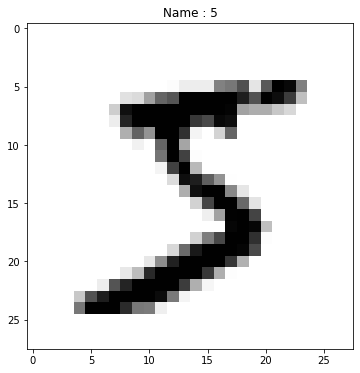

In [259]:
plt.figure(figsize = (12,6))
plt.imshow(image.numpy().transpose(1,2,0).reshape(28,28),cmap = "gist_yarg")
plt.title(f"Name : {label}")
plt.show()

In [260]:
torch.manual_seed(101)

train_loader = DataLoader(dataset = train_data , batch_size = 100, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = 100, shuffle = False)

In [261]:
for images,labels in train_loader:
    break

In [262]:
np.set_printoptions(formatter = dict(int = lambda x : f"{x:4}")) # Formating

In [263]:
# 60000/ 100 = 60
len(images),len(labels)

(100, 100)

In [264]:
images.shape

torch.Size([100, 1, 28, 28])

Labels :  [   7    2    3    5    8    5    3    6    9    9    1    3]


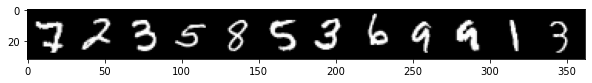

In [265]:
print("Labels : ", labels[:12].numpy())
img = make_grid(images[:12], nrow = 12)

plt.figure(figsize = (10,4))
plt.imshow(np.transpose(img.numpy(), (1,2,0)))
plt.show()

In [266]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, in_sz = 784, out_sz = 10, layers = [120,84]):
        super().__init__()

        self.fc1 = nn.Linear(in_sz , layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)

    def forward(self, X):

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim = 1) # Multi Class Classification

In [267]:
torch.manual_seed(101)
model = MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [268]:
# ANN ---> CNN
total_sum = []
for name,param in model.named_parameters():
    print(name, "\t", param.shape)
    print(param.numel())
    total_sum.append(param.numel())
    print("".center(100,"-"))
print()
print(np.array(total_sum).sum())

fc1.weight 	 torch.Size([120, 784])
94080
----------------------------------------------------------------------------------------------------
fc1.bias 	 torch.Size([120])
120
----------------------------------------------------------------------------------------------------
fc2.weight 	 torch.Size([84, 120])
10080
----------------------------------------------------------------------------------------------------
fc2.bias 	 torch.Size([84])
84
----------------------------------------------------------------------------------------------------
fc3.weight 	 torch.Size([10, 84])
840
----------------------------------------------------------------------------------------------------
fc3.bias 	 torch.Size([10])
10
----------------------------------------------------------------------------------------------------

105214


In [269]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [270]:
images.shape,labels.size()

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [271]:
images.view(100,-1).shape

torch.Size([100, 784])

In [274]:
import time
show = True

start_time = time.time()

# Traning
epochs = 10

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    
    trn_corr = 0.0
    tst_corr = 0.0

    trn_loss = 0.0
    tst_loss = 0.0

    for b, (X_train, y_train) in enumerate(train_loader):

        b+=1

        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]

        batch_corr = (predicted == y_train).sum()
        
        trn_corr+=batch_corr
        trn_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 200 == 0:
            acc = trn_corr.item()*100 / (100*b)
        
            print(f"Epoch : {epoch +1 :4}, Batch : {b:4}, [{b*100}/60000], Loss : {loss:4.4f}, Accuracy : {acc:.4f}%")
        
    else:

        with torch.no_grad():

             for X_test,y_test in test_loader:

                val_pred = model(X_test.view(100,-1))
                val_loss = criterion(val_pred, y_test)

                val_predicted = torch.max(val_pred, 1)[1]

                tst_loss+=val_loss.item()
                tst_corr+=(val_predicted == y_test).sum()

        train_loss = trn_loss / len(train_loader.dataset)
        test_loss = tst_loss / len(test_loader.dataset)

        train_corr = trn_corr.float()*100 / len(train_loader.dataset) 
        test_corr = tst_corr.float()*100 / len(test_loader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_correct.append(train_corr)
        test_correct.append(test_corr)

        if show :
            print()
            print("".center(100,"-"))   
            print()
            
            print(f"For Epoch : {epoch+1}")
            print("Training Loss : {:.10f} , Traning Accuracy : {:.4f}%".format(train_loss, train_corr.item()))
            print("Validation Loss : {:.10f}, Validation Accuracy : {:.4f}%".format(test_loss, test_corr.item()))
    
            print()
            print("".center(100,"-"))   
            print()

total_time = time.time() - start_time
print(f"\nDuration : {total_time / 60} Minutes...")

Epoch :    1, Batch :  200, [20000/60000], Loss : 0.2447, Accuracy : 94.8050%
Epoch :    1, Batch :  400, [40000/60000], Loss : 0.1454, Accuracy : 95.0625%
Epoch :    1, Batch :  600, [60000/60000], Loss : 0.0730, Accuracy : 95.3567%

----------------------------------------------------------------------------------------------------

For Epoch : 1
Training Loss : 0.0015786424 , Traning Accuracy : 95.3567%
Validation Loss : 0.0013476823, Validation Accuracy : 95.9400%

----------------------------------------------------------------------------------------------------

Epoch :    2, Batch :  200, [20000/60000], Loss : 0.0872, Accuracy : 96.5000%
Epoch :    2, Batch :  400, [40000/60000], Loss : 0.0670, Accuracy : 96.5950%
Epoch :    2, Batch :  600, [60000/60000], Loss : 0.0689, Accuracy : 96.6783%

----------------------------------------------------------------------------------------------------

For Epoch : 2
Training Loss : 0.0010887597 , Traning Accuracy : 96.6783%
Validation Los

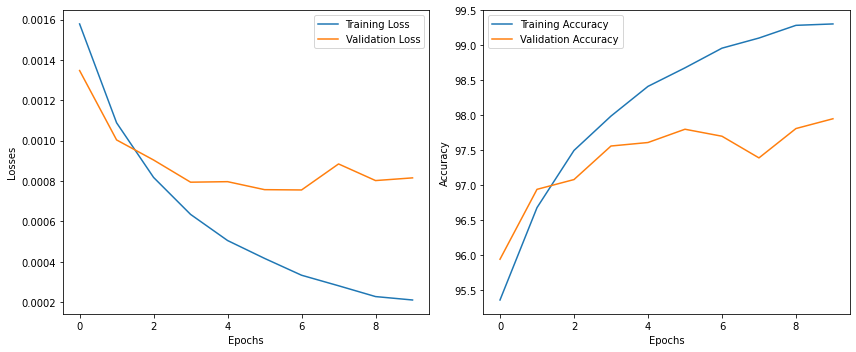

In [275]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.legend(loc = "best")
plt.ylabel("Losses")
plt.xlabel("Epochs")

plt.subplot(1,2,2)
plt.plot(train_correct,label = "Training Accuracy")
plt.plot(test_correct, label = "Validation Accuracy")
plt.legend(loc = "best")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.tight_layout()
plt.show()

In [276]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False )

with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val,1)[1]
        correct +=(predicted == y_test).sum()

In [277]:
print("Test Accuracy Score : {:.4f}%".format((correct*100 )/ len(X_test)))

Test Accuracy Score : 97.9500%


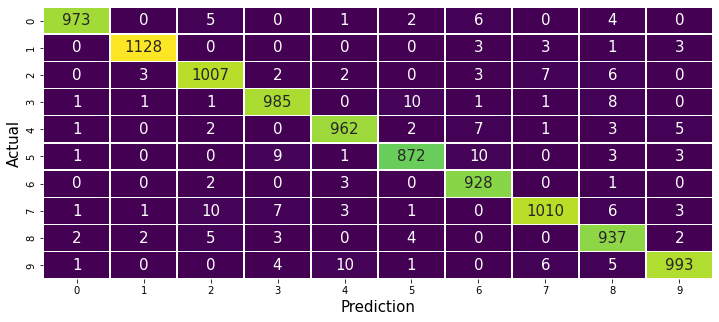

In [278]:
import seaborn as sns

cm = confusion_matrix(predicted,y_test)

plt.figure(figsize = (12,5))
sns.heatmap(cm, annot = True,fmt = "d", annot_kws = {"size" : 15}, cbar = False, cmap = "viridis",linewidths=0.4,linecolor = "white")
plt.xlabel("Prediction",fontsize =15)
plt.ylabel("Actual",fontsize =15)
plt.show()

In [279]:
predicted.shape

torch.Size([10000])

In [280]:
# index buluyoruz burda dikkat !!!!

misses = np.array([])
for i in range(len(predicted)):
    if predicted[i] != y_test[i]:
        misses = np.append(misses, i).astype("int64")

len(misses)

205

In [281]:
misses[:10]

array([  61,  149,  151,  217,  247,  259,  321,  340,  381,  445])

In [282]:
len(misses) // (12 + 1)

15

In [283]:
r = 12
row = iter(np.array_split(misses, len(misses) // r + 1))
next(row)

array([  61,  149,  151,  217,  247,  259,  321,  340,  381,  445,  495,
        582])

Index :  [ 583  691  720  740  844  947  951  956  965 1014 1039 1044]
Label :  [   2    8    5    4    8    8    5    1    6    6    7    6]
Guess :  [   7    7    8    9    7    9    4    2    0    5    2    2]


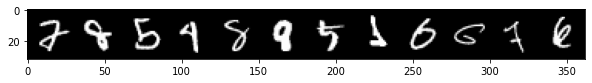

In [284]:
nextrow = next(row)

print("Index : ",nextrow )
print("Label : ", y_test.index_select(0, torch.tensor(nextrow)).numpy() )
print("Guess : ", predicted.index_select(0, torch.tensor(nextrow)).numpy() )

images = X_test.index_select(0, torch.tensor(nextrow))
img = make_grid(images, nrow = r)
plt.figure(figsize = (10,4))
plt.imshow(np.transpose(img.numpy(), (1,2,0)));

----

In [246]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torchvision import transforms,datasets,models
from torch.utils.data import DataLoader,TensorDataset

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [255]:
transform = transforms.Compose([ transforms.ToTensor() ])

train_data = datasets.MNIST(root = "../Data",train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = "../Data",train = False, download = True, transform = transform)

In [285]:
train_loader = DataLoader(dataset = train_data, batch_size = 10 , shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = 10, shuffle = False)

In [286]:
# 1 color channel, 6 filters, 3by3 kernel, strides = 1
conv1 = nn.Conv2d(1, 6, 3, 1)

# 6 Input Filters, 16 filters, 3by3 kernel, strides = 1
conv2 = nn.Conv2d(6, 16, 3, 1)

In [295]:
for i, (X_train,y_train) in enumerate(train_data):
    break

In [298]:
x = X_train.view(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

In [299]:
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 26, 26])

In [301]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 6, 13, 13])

In [302]:
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [303]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 5, 5])

In [304]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

In [305]:
class ConvolutionalNetwork(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim = 1)

In [324]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [325]:
for name,param in model.named_parameters():
    print(name,"\t",param.shape)
    print("----------")

conv1.weight 	 torch.Size([6, 1, 3, 3])
----------
conv1.bias 	 torch.Size([6])
----------
conv2.weight 	 torch.Size([16, 6, 3, 3])
----------
conv2.bias 	 torch.Size([16])
----------
fc1.weight 	 torch.Size([120, 400])
----------
fc1.bias 	 torch.Size([120])
----------
fc2.weight 	 torch.Size([84, 120])
----------
fc2.bias 	 torch.Size([84])
----------
fc3.weight 	 torch.Size([10, 84])
----------
fc3.bias 	 torch.Size([10])
----------


In [326]:
total_param = []

for param in model.parameters():
    print(param.numel())
    total_param.append(param.numel())

print("".center(100,"-"))
print(np.array(total_param).sum())

54
6
864
16
48000
120
10080
84
840
10
----------------------------------------------------------------------------------------------------
60074


In [327]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [328]:
import time
show = True

start_time = time.time()

# Traning
epochs = 5

# Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    
    trn_corr = 0.0
    tst_corr = 0.0

    trn_loss = 0.0
    tst_loss = 0.0

    for b, (X_train, y_train) in enumerate(train_loader):

        b+=1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]

        batch_corr = (predicted == y_train).sum()
        
        trn_corr+=batch_corr
        trn_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 1000 == 0:
            acc = trn_corr.item()*100 / (10*b)
        
            print(f"Epoch : {epoch +1 :4}, Batch : {b:4}, [{b*10}/60000], Loss : {loss:4.4f}, Accuracy : {acc:.4f}%")
        
    else:

        with torch.no_grad():

             for X_test,y_test in test_loader:

                val_pred = model(X_test)
                val_loss = criterion(val_pred, y_test)

                val_predicted = torch.max(val_pred, 1)[1]

                tst_loss+=val_loss.item()
                tst_corr+=(val_predicted == y_test).sum()

        train_loss = trn_loss / len(train_loader.dataset)
        test_loss = tst_loss / len(test_loader.dataset)

        train_corr = trn_corr.float()*100 / len(train_loader.dataset) 
        test_corr = tst_corr.float()*100 / len(test_loader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_correct.append(train_corr)
        test_correct.append(test_corr)

        if show :
            print()
            print("".center(100,"-"))   
            print()
            
            print(f"For Epoch : {epoch+1}")
            print("Training Loss : {:.10f} , Traning Accuracy : {:.4f}%".format(train_loss, train_corr.item()))
            print("Validation Loss : {:.10f}, Validation Accuracy : {:.4f}%".format(test_loss, test_corr.item()))
    
            print()
            print("".center(100,"-"))   
            print()

total_time = time.time() - start_time
print(f"\nDuration : {total_time / 60} Minutes...")

Epoch :    1, Batch : 1000, [10000/60000], Loss : 0.8559, Accuracy : 84.2100%
Epoch :    1, Batch : 2000, [20000/60000], Loss : 0.2693, Accuracy : 89.4450%
Epoch :    1, Batch : 3000, [30000/60000], Loss : 0.0084, Accuracy : 91.6800%
Epoch :    1, Batch : 4000, [40000/60000], Loss : 0.0016, Accuracy : 92.9600%
Epoch :    1, Batch : 5000, [50000/60000], Loss : 0.0311, Accuracy : 93.7860%
Epoch :    1, Batch : 6000, [60000/60000], Loss : 0.0580, Accuracy : 94.3700%

----------------------------------------------------------------------------------------------------

For Epoch : 1
Training Loss : 0.0180256247 , Traning Accuracy : 94.3700%
Validation Loss : 0.0072295405, Validation Accuracy : 97.6900%

----------------------------------------------------------------------------------------------------

Epoch :    2, Batch : 1000, [10000/60000], Loss : 0.0008, Accuracy : 97.8700%
Epoch :    2, Batch : 2000, [20000/60000], Loss : 0.0017, Accuracy : 97.8550%
Epoch :    2, Batch : 3000, [30000

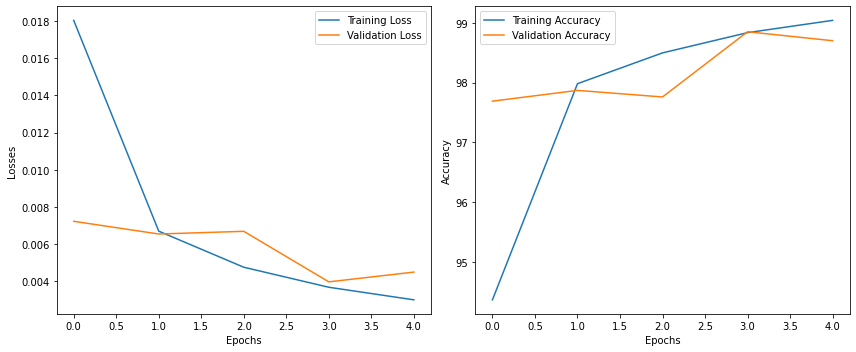

In [329]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.legend(loc = "best")
plt.ylabel("Losses")
plt.xlabel("Epochs")

plt.subplot(1,2,2)
plt.plot(train_correct,label = "Training Accuracy")
plt.plot(test_correct, label = "Validation Accuracy")
plt.legend(loc = "best")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.tight_layout()
plt.show()

In [331]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False )

with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct +=(predicted == y_test).sum()

In [332]:
# ANN -- > 97.9500%
print("Test Accuracy Score : {:.4f}%".format((correct*100 )/ len(X_test)))

Test Accuracy Score : 98.7000%


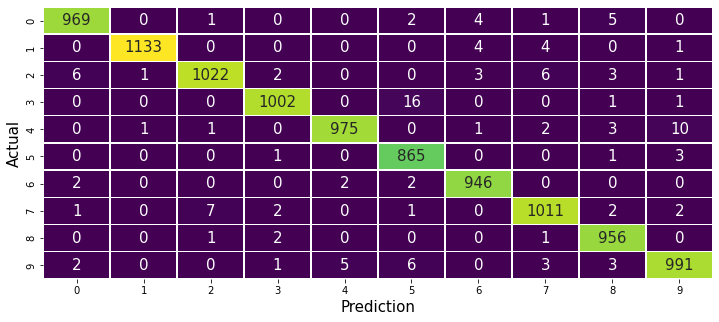

In [333]:
import seaborn as sns

cm = confusion_matrix(predicted,y_test)

plt.figure(figsize = (12,5))
sns.heatmap(cm, annot = True,fmt = "d", annot_kws = {"size" : 15}, cbar = False, cmap = "viridis",linewidths=0.4,linecolor = "white")
plt.xlabel("Prediction",fontsize =15)
plt.ylabel("Actual",fontsize =15)
plt.show()

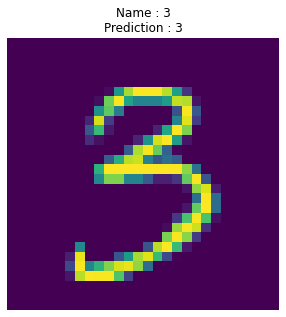

In [350]:
plt.figure(figsize = (12,5))

plt.imshow(X_test[2020].numpy().transpose(1,2,0).reshape(28,28))
pred = model(X_test[2020].reshape(1,1,28,28))
pred = torch.max(pred,1)[1]
plt.title(f"Name : {y_test[2020]}\nPrediction : {pred.item()}")
plt.axis("off")
plt.show()

In [345]:
X_test[2020].reshape(1,1,28,28)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [351]:
# Index buluyoruz burda dikkat !!!!

misses = np.array([])
for i in range(len(predicted)):
    if predicted[i] != y_test[i]:
        misses = np.append(misses, i).astype("int64")

len(misses)

130

In [352]:
misses[:10]

array([  18,  321,  340,  359,  445,  490,  495,  582,  659,  674])

In [353]:
r = 12
row = iter(np.array_split(misses, len(misses) // r+1))

Index :  [1955 2035 2070 2109 2125 2130 2135 2293 2387 2414 2447 2488]
Label :  [   8    5    7    3    5    4    6    9    9    9    4    2]
Guess :  [   2    3    0    7    9    9    1    4    1    4    9    4]


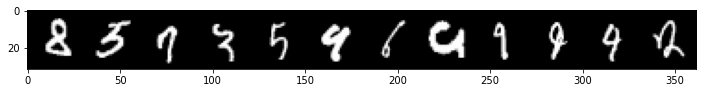

In [357]:
nextrow = next(row)

print("Index : ", nextrow)
print("Label : ", y_test.index_select(0, torch.tensor(nextrow)).numpy() )
print("Guess : ", predicted.index_select(0, torch.tensor(nextrow)).numpy() )

images = X_test.index_select(0, torch.tensor(nextrow))
img = make_grid(images, nrow = r)

plt.figure(figsize = (12,5))
plt.imshow(img.numpy().transpose(1,2,0))
plt.show()

---

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
#torch.cuda.current_device()

In [3]:
#torch.cuda.get_device_name(0)

In [4]:
torch.cuda.memory_allocated()

0

In [5]:
a = torch.FloatTensor([1.0,2.0])
a

tensor([1., 2.])

In [7]:
#a.device()

In [8]:
#a = torch.FloatTensor([1.0,2.0]).cuda()
#a.device